In [522]:
import pandas as pd
import numpy as np
import evaluation

## load_data

In [523]:
# load prices
prices = pd.read_csv('close_prices_no_fx_insample.csv', index_col='AsOfDate', parse_dates=['AsOfDate'])
ret = prices.diff()

<Axes: xlabel='AsOfDate'>

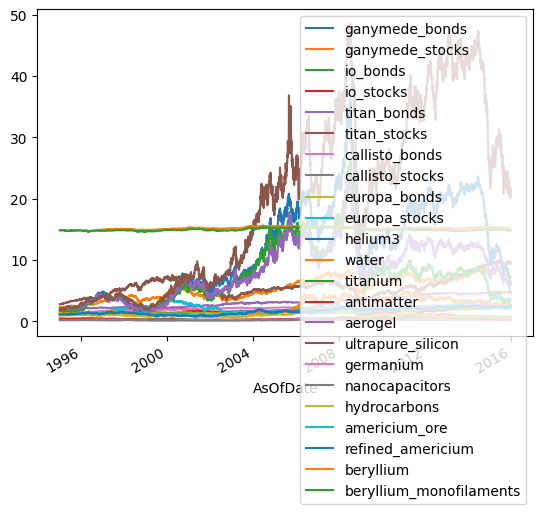

In [524]:
prices.plot()

## enter your own trading strategy here

## soft clipping

In [525]:
def soft_clip(x, lower_bound, upper_bound, smoothness=10):
    """Smoothly clips values between lower_bound and upper_bound."""
    return lower_bound + (upper_bound - lower_bound) / (1 + np.exp(-smoothness * (x - (lower_bound + upper_bound) / 2)))


## exponential averages

In [531]:
def ema_bollinger_strategy(price, short_ema=30, long_ema=200, bb_window=50, bb_std=3, vol_window=252, atr_window=50, sl_mult=2, tp_mult=4):

    # Exponential Moving Averages (Trend Indicator)
    ema_short = price.ewm(span=short_ema, adjust=False).mean()
    ema_long = price.ewm(span=long_ema, adjust=False).mean()

    # Bollinger Bands (Mean Reversion)
    sma = price.rolling(bb_window).mean()
    std = price.rolling(bb_window).std()
    upper_band = sma + bb_std * std
    lower_band = sma - bb_std * std

    threshold = 0.02

    # Trend Signal (EMA Crossover)
    trend_signal = np.where((ema_short > ema_long * (1 + threshold)), 1,
                            np.where((ema_short < ema_long * (1 - threshold)), -1, 0))

    # Bollinger Band Signal (Mean Reversion)
    bb_signal = np.where(price > upper_band, -1,
                         np.where(price < lower_band, 1, 0))

    # Combined Signal (Trend + Mean Reversion)
    position = trend_signal + bb_signal
    position = soft_clip(position, lower_bound=-1, upper_bound=1, smoothness=10)


    vol = np.sqrt((ret**2).rolling(window=vol_window, min_periods=vol_window//2).sum())

    position = (position / vol)

    position = pd.DataFrame(position, index=price.index, columns=price.columns)

    # --- ATR-based Stop Loss & Take Profit ---
    high = price.rolling(atr_window).max()
    low = price.rolling(atr_window).min()
    close_prev = price.shift(1)

    true_range = np.maximum(high - low, np.maximum(abs(high - close_prev), abs(low - close_prev)))
    atr = true_range.rolling(atr_window).mean()  # Average True Range

    # Define Stop Loss & Take Profit dynamically based on ATR
    sl_level = sl_mult * atr
    tp_level = tp_mult * atr

    # Track Entry Price & Active Position
    entry_price = pd.DataFrame(np.nan, index=price.index, columns=price.columns)
    active_position = pd.DataFrame(0, index=price.index, columns=price.columns)

    for i in range(1, len(price)):
        for col in price.columns:
            if position.iloc[i, price.columns.get_loc(col)] != 0:  # New position detected
                if active_position.iloc[i-1, price.columns.get_loc(col)] == 0:  # First time entering trade
                    entry_price.iloc[i, price.columns.get_loc(col)] = price.iloc[i, price.columns.get_loc(col)]
                    active_position.iloc[i, price.columns.get_loc(col)] = position.iloc[i, price.columns.get_loc(col)]
                else:  # Continue tracking position
                    entry_price.iloc[i, price.columns.get_loc(col)] = entry_price.iloc[i-1, price.columns.get_loc(col)]
                    active_position.iloc[i, price.columns.get_loc(col)] = active_position.iloc[i-1, price.columns.get_loc(col)]
            else:
                entry_price.iloc[i, price.columns.get_loc(col)] = np.nan
                active_position.iloc[i, price.columns.get_loc(col)] = 0

    # Compute % change from entry price
    price_change = price - entry_price

    # Stop Loss & Take Profit Conditions
    stop_loss = (price_change < -sl_level) & (active_position != 0)
    take_profit = (price_change > tp_level) & (active_position != 0)

    # Exit positions if SL or TP is hit
    position[stop_loss | take_profit] = 0

    return position




position = ema_bollinger_strategy(prices)

## average positions

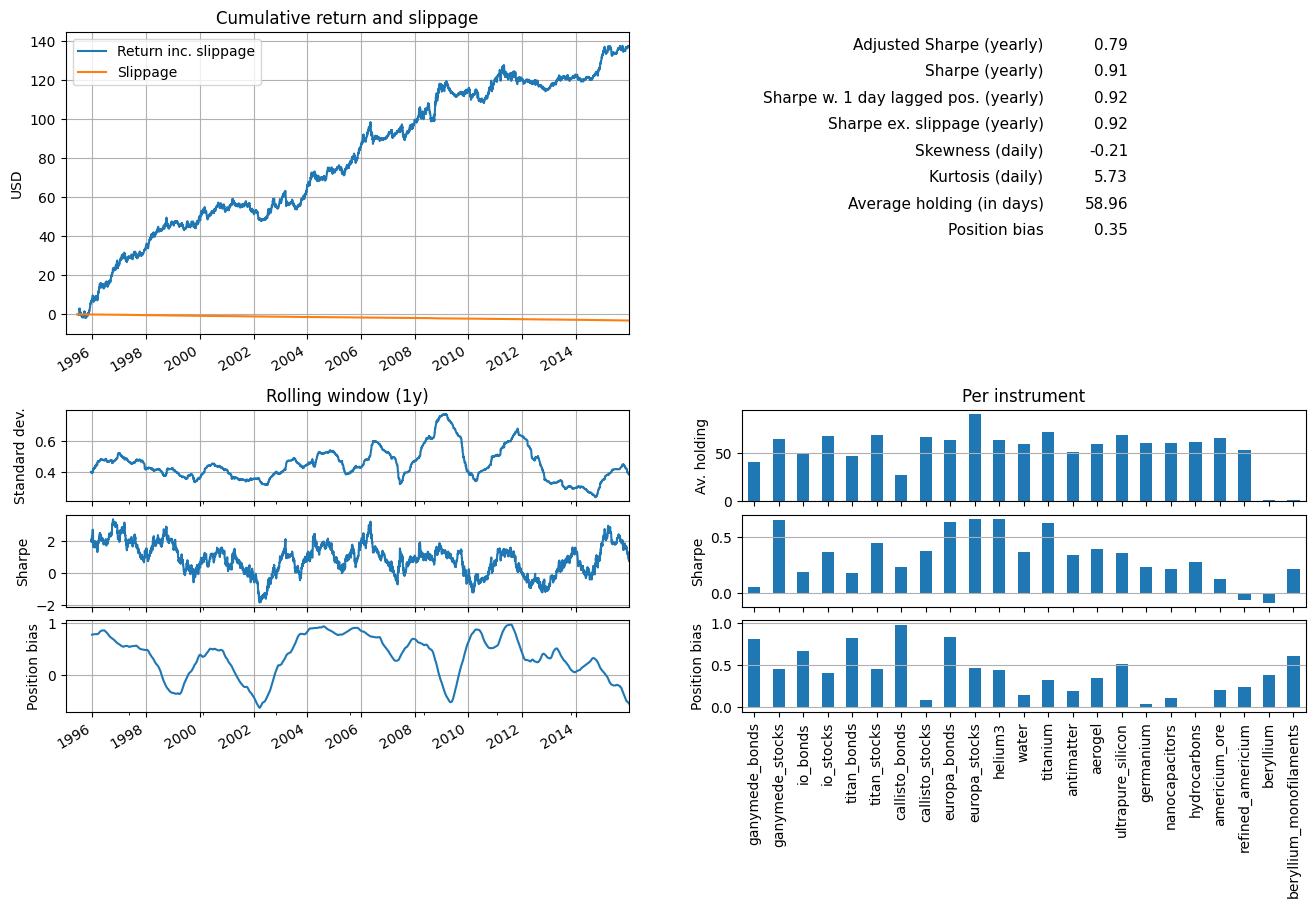

In [532]:
evaluation.plot_key_figures(position, prices)

## save your positions to a file

In [528]:
position.to_csv('results.csv')